# Coronavirus propagation visualization. 
# Part 1: History of Coronavirus.

change_lavel-row to colums_kr.ipynb
실행

DataSet
https://github.com/CSSEGISandData/COVID-19
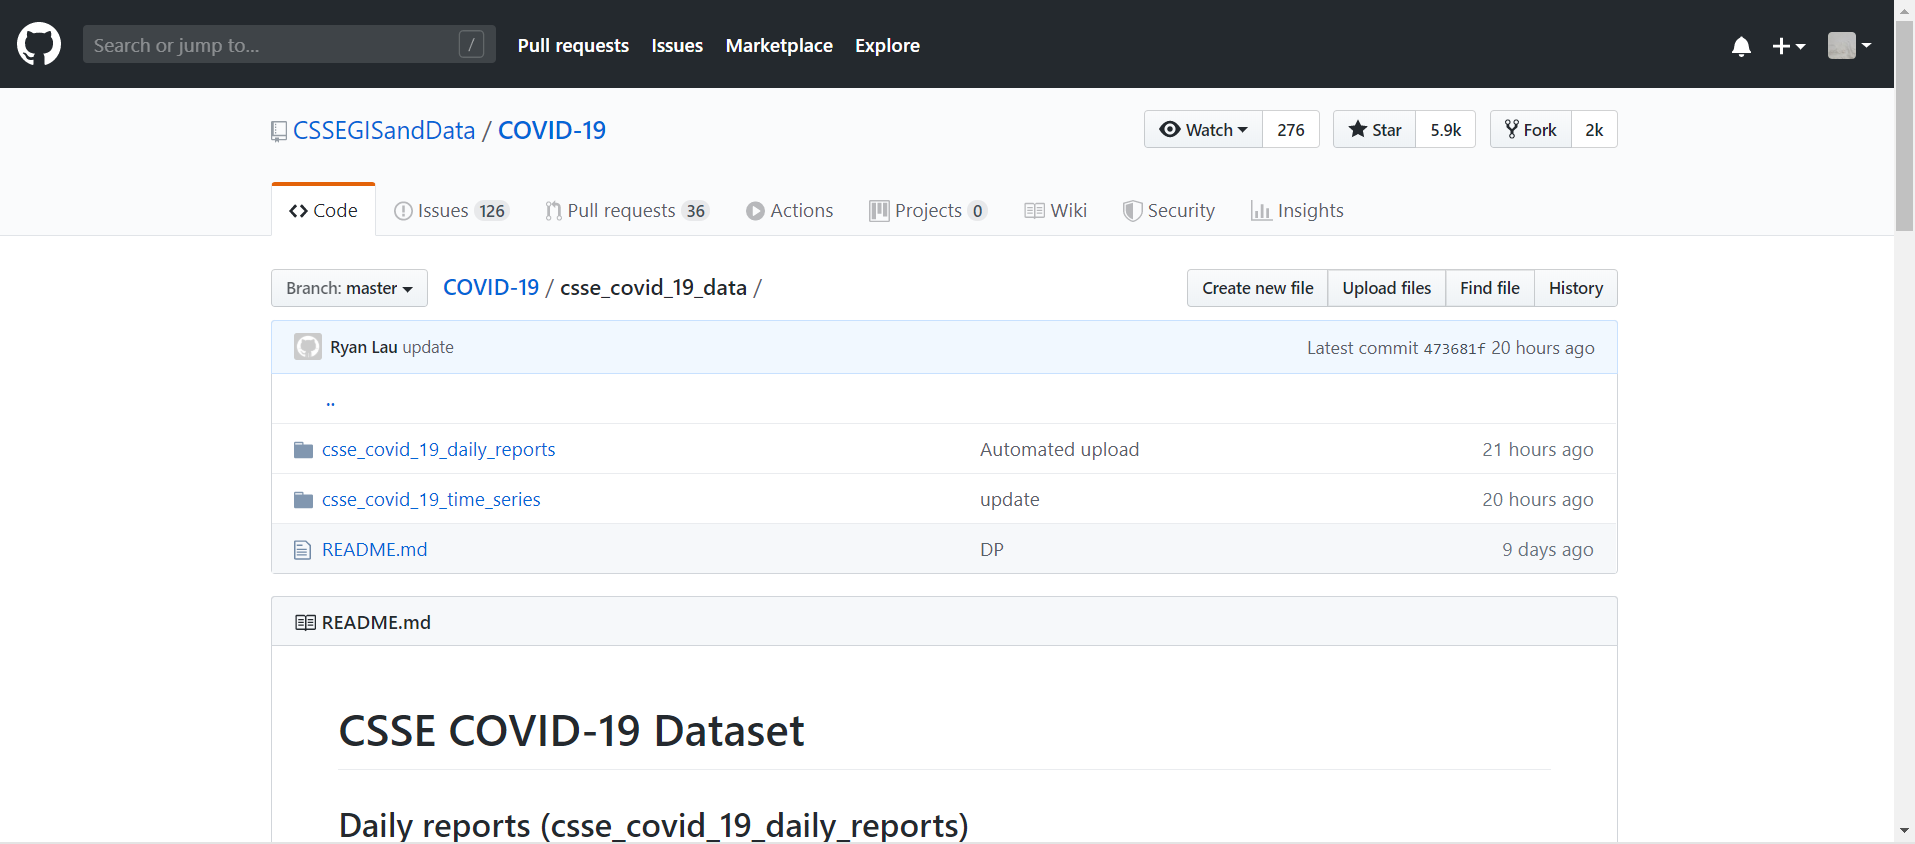

### Imports

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import math
from collections import namedtuple

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, TimestampedGeoJson

import datetime
import os


import json
from folium.features import DivIcon

In [ ]:
# import os
# for dirname, _, filenames in os.walk('../bokeh-app/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
# df = pd.read_csv('../bokeh-app/input/dataset/2019_nCoV_20200121_20200127.csv')
# df = pd.read_csv("C:/Users/MSI/Untitled Folder/result.csv",  'rt', encoding='UTF8')
# df = pd.read_csv("C:/Users/MSI/Untitled Folder/result.csv")
geo_path = '../bokeh-app/input/geo/Si-Do/TL_SCCO_CTPRVN.json'
kr_geo_data = json.load(open(geo_path, encoding='utf-8'))

# df_rec = pd.read_csv('../bokeh-app/input/coronavirus-latlon-dataset/CV_LL_recovered.csv')
df_con = pd.read_csv('C:/Users/MSI/Untitled Folder/corona_con_kor.csv')
df_on = pd.read_csv('C:/Users/MSI/Untitled Folder/corona_con_kor.csv')
# df_death= pd.read_csv('../bokeh-app/input/coronavirus-latlon-dataset/CV_LL_death.csv')

In [ ]:
df_con.head()

In [ ]:
def prepare_df_date(df):
    # turning date field into timestamps
    df['date'] = pd.to_datetime(df['date'])
    # geocoding does not know about 'Mainland China', so lets fix it into an API acceptable form
#     df.loc[df['Country/Region'] == 'Mainland China', 'Country/Region'] = 'China'
    # also geocoding does not like deal with NAs
    df['Confirmed'] = df['Confirmed'].fillna(0)
    return df

In [ ]:
# df = prepare_df(df)
# df_rec = prepare_df_date(df_rec)
df_con = prepare_df_date(df_con)
df_on = prepare_df_date(df_on)
# df_con = prepare_df(df_con)
# df_death = prepare_df_date(df_death)

In [ ]:
df_con.head()

In [ ]:
df_on.dtypes

### Animation

The animation part for some reason is not really obvious within the folium library. There is one option to animate HeatMaps, but recently it stopped working, as well as options to animate routes, and marker positions through GeoJason. So the only way I found to actually indicate the development of situation with virus, is to make a bunch of screenshots, and feed them into the gif or video animation as frames. 

### Combo map. Animation, all three stauses (confirmed/death/recovered), choropleth.

The function below is creating a mighty GoeJson that carries our timestamped layers to the folium map.

In [ ]:
def create_geojson_features(df_con,df_on,
                            radius_max=1000,
                            radius_min = 2, 
                            fill_color_confirmed = '#FC766AFF',
                            fill_color_recovered = '#0A5E2AFF',
                            fill_color_death = '#E80018',
                            weight = 1,
                            fill_opacity = 0.5
                            ):

    print('> Creating GeoJSON features...')

    features = []
    feature = []
    # df_con
    for _, row in df_con.iterrows():
        radius = np.sqrt(row['Confirmed'])
        if radius != 0:
          if radius < radius_min:
            radius = radius_min

          if radius > radius_max:
            radius = radius_max
            
          popup = str(row['city']) + str(row['Confirmed'])
        
          feature = {
              'type': 'Feature',
              'geometry': {
                  'type':'Point', 
                  'coordinates':[row['longitude'],row['latitude']]
              },
              'properties': {
                  'time': row['date'].__str__(),
                  'style': {'color' : fill_color_confirmed},
                  'icon': 'circle',
                  'iconstyle':{
                      'fillColor': fill_color_confirmed,
                      'fillOpacity': fill_opacity,
                      'stroke': 'true',
                      'radius': radius,
                      'weight': weight,
                      'popup': popup
                  }
              }
        }
        features.append(feature)
        
    for _, row in df_on.iterrows():
        radius = np.sqrt(row['Confirmed'])
        if radius != 0:
          if radius < radius_min:
            radius = radius_min

          if radius > radius_max:
            radius = radius_max
        popups = str(row['city']) + str(row['Confirmed'])
        size=radius,radius
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point',
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['date'].__str__(),
                'style': {'color' : fill_color_confirmed},
                'icon': 'marker',
                'iconstyle': { 'iconUrl': 'https://cdn.iconscout.com/icon/premium/png-512-thumb/coronavirus-4-613136.png', 
                              'iconSize': [radius, radius],
                              'fillOpacity': 0.1,
                              'Popup': popups
                             }
            }
        }
        features.append(feature)
        

    
    print('> finishing GeoJSON features...')
    return features


This function gets the GeoJson into the folium map.

In [ ]:
def make_map(features, caption):
    print('> Making map...')
    coords=[36, 127]
    map = folium.Map(location=coords, 
                               control_scale=True, 
                               zoom_start=6.5,
                               tiles='cartodbpositron',  
                               detect_retina = True
                              )
    
    folium.Choropleth(
        geo_data=kr_geo_data,
        name='choropleth',
        key_on='feature.properties.name',
        fill_color='yellow',
        fill_opacity=0.15,
        line_opacity=0.7
        ).add_to(map)


    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1D'
        , duration='P1D'
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='MM/DD/YYYY'
        , time_slider_drag_update=True
        , transition_time = 500
    ).add_to(map)
    
#     add_child(folium.marker
# #     map.add_child(folium.Popup(Popup))

    
    
# #     folium.CircleMarker([37.5658859, 126.9754788], radius=100,color='#3186cc',fill_color='#3186cc', popup='1').add_child(folium.Popup('My name is Circle')).add_to(map)
#     map.add_child(folium.map.Marker(
#     [37.5658859, 126.9754788],
#     icon=DivIcon(
#         icon_size=(150,36),
#         icon_anchor=(0,0),
#         html='<div style="font-size: 24pt">%s</div>',
#         )
#     ))
    
    map.caption = caption
    print('> Done.')
    map.save(os.path.join('Corona_kr.html'))
    
    return map

In [ ]:
features = create_geojson_features(df_con, df_on, fill_opacity=0.3, weight = 1)
make_map(features, caption = "Coronavirus propagation in korea, 2020.")

In [ ]:
# url = 'D:/Programming/Github/Bigdata/Coronavirus-Dataset/time.csv'
# Origin_df = pd.read_csv(url)
# Origin_df=pd.DataFrame(Origin_df, columns=['date','confirmed','released','deceased'])
# Origin_df['date'] = pd.to_datetime(Origin_df['date'])
# Origin_df.head()
# # negative: 누적 음성 결과 수
# # confirmed: 누적 양성 결과 수 (확진)
# # released: 누적 격리 해제 수
# # deceased: 누적 사망 수

In [ ]:
# from bokeh.models import ColumnDataSource
# from bokeh.plotting import output_notebook, figure, show
# from bokeh.palettes import Blues8, Spectral3


# plot = figure(plot_width=1200, plot_height=600, title='Corona19 virus graph in Korea', x_axis_label='date',x_axis_type='datetime',
#               y_axis_label='Peoples')
    
# plot.line(Origin_df['date'], Origin_df['confirmed'], line_width=2, line_color='green', legend_label='Confirmed')
# plot.circle(Origin_df['date'], Origin_df['confirmed'], fill_color="green",line_color='green', size=8)
# plot.line(Origin_df['date'], Origin_df['released'], line_width=2, line_color='blue', legend_label='Released')
# plot.circle(Origin_df['date'], Origin_df['released'], fill_color="blue",line_color='blue', size=8)
# plot.line(Origin_df['date'], Origin_df['deceased'], line_width=2, line_color='red', legend_label='Dethed')
# plot.circle(Origin_df['date'], Origin_df['deceased'], fill_color="red",line_color='red', size=8)

# plot.legend.location = "top_left"
# plot.label_text_font_size: "36pt"
# plot.legend.border_line_color = "navy"

# show(plot)

There are  issues that I wasn't able to fix this time: 
1. Folium 모듈로 전세계지도에 숫자를 표현하는게 힘들 것 같다.
2. 현제 까지 지속적으로 업데이트 dataset 전처리 과정에서 나라 이름과 위도경도가 일정한 패턴으로 제공하지 않는다. 

* 추후 HTML로 사이트에 올리거나 동영상으로 제작할 계획이다.
* 한국 지도에 코로나바이러스를 표시할 예정


## End of Part!

이 글은 코로나 바이러스의 과거와 현재 상황을 다룹니다. 두 번째 부분에서는 미래를 살펴보고 현재 상황이 변하지 않을 경우 바이러스가 새로운 영토로 어떻게 이동하는지에 대한 힌트를 얻으려고합니다.

지도 애니메이션을 더 잘 만드는 방법에 대한 의견을 보내 주셔서 감사합니다. 또한 비행 정보를 시각화하여 바이러스의 전파에 미치는 영향을 더 잘 파악할 수있는 솔루션을 찾고 있습니다.